In [1]:
import numpy as np 
import pandas as pd 
import torch 
import torch.nn as nn 
import torchvision
from torchvision.transforms import transforms
import time
import numpy as np
from continuum.continuum import continuum
from continuum.data_utils import setup_test_loader
from utils.name_match import agents
from utils.setup_elements import setup_opt, setup_architecture
from utils.utils import maybe_cuda
from experiment.metrics import compute_performance, single_run_avg_end_fgt
from experiment.tune_hyperparam import tune_hyper
from types import SimpleNamespace
from utils.io import load_yaml, save_dataframe_csv, check_ram_usage
import pandas as pd
import os
import pickle
import torch

In [2]:
import numpy as np
from torchvision import datasets
from continuum.data_utils import create_task_composition, load_task_with_labels, shuffle_data
from continuum.dataset_scripts.dataset_base import DatasetBase
from continuum.non_stationary import construct_ns_multiple_wrapper, test_ns

In [3]:
import torch
from torch.utils import data
from utils.buffer.buffer import Buffer
from agents.base import ContinualLearner
from continuum.data_utils import dataset_transform
from utils.setup_elements import transforms_match
from utils.utils import maybe_cuda, AverageMeter

## Setup Config

In [4]:
class Parameters:
    num_runs = 1
    seed = 1
    val_size = 1
    num_val  = 3
    num_runs_val = 3
    error_analysis = 3
    verbose = 0
    agent = "ER"
    update = 'random'
    retrieve = "random"
    weight_decay = 0
    num_tasks = 4
    fix_order = False
    plot_sample = False
    optimizer = 'SGD'
    learning_rate = 0.1
    epoch = 10
    batch = 10
    trick = {'labels_trick':False,
             'kd_trick':False,
             'kd_trick_star':False,
             "review_trick":False,
             "separated_softmax":False,
             "ncm_trick":False}
    data = "breathing"
    test_batch = 128
    retrieve = 'random'
    cl_type = 'nc'
    ns_factor = (0.0, 0.4, 0.8, 1.2, 1.6, 2.0, 2.4, 2.8, 3.2, 3.6)
    ns_type = "noise"
    ns_task = (1, 1, 2, 2, 2, 2)
    online = True
    mem_size = 0
    eps_mem_batch = 10
    lambda_ = 100
    alpha = 0.9
    fisher_update_after = 50
    subsample = 50 
    gss_mem_strength = 10 # Number of batches randomly sampled from memory to estimate score
    gss_batch_size = 10 #Random sampling batch size to estimate score
    k = 5 #Number of nearest neighbors (K) to perform ASER
    aser_type = "asvm"
    n_smp_cls = 2.0
    stm_capacity = 1000
    classifier_chill = 0.01 
    log_alpha = 300.0
    minlr = 0.0005 #Minimal learning rate
    clip = 10 #value for gradient clipping
    mem_epoch = 10 #Epochs to train for memory
    labels_trick = False
    separated_softmax = False
    kd_trick = False#Knowledge distillation with cross entropy trick
    kd_trick_star = False #Improved knowledge distillation trick
    review_trick = False
    ncm_trick = False #Use nearest class mean classifier
    mem_iters = 1 #
    min_delta = 0# A minimum increase in the score to qualify as an improvement
    patience = 0 # Number of events to wait if no improvement and then stop the training.
    cumulative_delta = False  # If True, `min_delta` defines an increase since the last `patience` reset,otherwise, it defines an increase after the last event.
    temp = 0.07 #temperature for loss function
    buffer_tracker = False #Keep track of buffer with a dictionary
    warmup = 4 #warmup of buffer before retrieve
    head = 'mlp'#projection head
    cuda = torch.cuda.is_available()

In [5]:
params = Parameters

In [6]:
from utils.name_match import data_objects
from continuum.dataset_scripts.breathing import BreathDataset

from continuum.dataset_scripts.breathdata_v2 import BreathDataset_v2


In [12]:
data_objects['breathing'] = BreathDataset
data_objects['breathing_v2'] = BreathDataset_v2

### Build Agent

In [57]:
class ExperienceReplay(ContinualLearner):
    def __init__(self, model, opt, params):
        super(ExperienceReplay, self).__init__(model, opt, params)
        self.buffer = Buffer(model, params)
        self.mem_size = params.mem_size
        self.eps_mem_batch = params.eps_mem_batch
        self.mem_iters = params.mem_iters
        self.loss_epochs = []
        self.acc_epochs = []
        self.loss_mem_epochs = []
        self.acc_mem_epochs = []

        self.losses_batch = AverageMeter()
        self.losses_mem = AverageMeter()
        self.acc_batch = AverageMeter()
        self.acc_mem = AverageMeter()

    def train_learner(self, x_train, y_train):
        self.before_train(x_train, y_train)
        # set up loader
        train_dataset = dataset_transform(x_train, y_train, transform=transforms_match[self.data])
        train_loader = data.DataLoader(train_dataset, batch_size=self.batch, shuffle=True, num_workers=0,
                                       drop_last=True)
        # set up model
        self.model = self.model.train()
    
        # setup tracker
        # losses_batch = AverageMeter()
        # losses_mem = AverageMeter()
        # acc_batch = AverageMeter()
        # acc_mem = AverageMeter()

        for ep in range(self.epoch):
            for i, batch_data in enumerate(train_loader):
                # batch update
                batch_x, batch_y = batch_data
                # print("batch data:", batch_x.size())
                batch_x = maybe_cuda(batch_x, self.cuda)
                batch_y = maybe_cuda(batch_y, self.cuda)
                # print(batch_x.size())
                batch_x = batch_x.view(batch_x.size(0), batch_x.size(2), batch_x.size(3))
                # print(batch_x.size())
                for j in range(self.mem_iters):
                    # batch_x = batch_x.view(batch_x.size(0), batch_x.size(2), batch_x.size(3))
                    logits = self.model.forward(batch_x)
                    loss = self.criterion(logits, batch_y)
                    if self.params.trick['kd_trick']:
                        loss = 1 / (self.task_seen + 1) * loss + (1 - 1 / (self.task_seen + 1)) * \
                                   self.kd_manager.get_kd_loss(logits, batch_x)
                    if self.params.trick['kd_trick_star']:
                        loss = 1/((self.task_seen + 1) ** 0.5) * loss + \
                               (1 - 1/((self.task_seen + 1) ** 0.5)) * self.kd_manager.get_kd_loss(logits, batch_x)
                    _, pred_label = torch.max(logits, 1)
                    correct_cnt = (pred_label == batch_y).sum().item() / batch_y.size(0)
                    # update tracker
                    self.acc_batch.update(correct_cnt, batch_y.size(0))
                    self.losses_batch.update(loss, batch_y.size(0))
                    # backward
                    self.opt.zero_grad()
                    loss.backward()

                    # mem update
                    mem_x, mem_y = self.buffer.retrieve(x=batch_x, y=batch_y)
                    if mem_x.size(0) > 0:
                        mem_x = maybe_cuda(mem_x, self.cuda)
                        mem_y = maybe_cuda(mem_y, self.cuda)
                        mem_logits = self.model.forward(mem_x)
                        loss_mem = self.criterion(mem_logits, mem_y)
                        if self.params.trick['kd_trick']:
                            loss_mem = 1 / (self.task_seen + 1) * loss_mem + (1 - 1 / (self.task_seen + 1)) * \
                                       self.kd_manager.get_kd_loss(mem_logits, mem_x)
                        if self.params.trick['kd_trick_star']:
                            loss_mem = 1 / ((self.task_seen + 1) ** 0.5) * loss_mem + \
                                   (1 - 1 / ((self.task_seen + 1) ** 0.5)) * self.kd_manager.get_kd_loss(mem_logits,
                                                                                                         mem_x)
                        # update tracker
                        self.losses_mem.update(loss_mem, mem_y.size(0))
                        _, pred_label = torch.max(mem_logits, 1)
                        correct_cnt = (pred_label == mem_y).sum().item() / mem_y.size(0)
                        self.acc_mem.update(correct_cnt, mem_y.size(0))

                        loss_mem.backward()

                    if self.params.update == 'ASER' or self.params.retrieve == 'ASER':
                        # opt update
                        self.opt.zero_grad()
                        combined_batch = torch.cat((mem_x, batch_x))
                        combined_labels = torch.cat((mem_y, batch_y))
                        combined_logits = self.model.forward(combined_batch)
                        loss_combined = self.criterion(combined_logits, combined_labels)
                        loss_combined.backward()
                        self.opt.step()
                    else:
                        self.opt.step()

                # update mem
                self.buffer.update(batch_x, batch_y)

                if i % 100 == 1 and self.verbose:
                    print(
                        '==>>> it: {}, avg. loss: {:.6f}, '
                        'running train acc: {:.3f}'
                            .format(i, self.losses_batch.avg(), self.acc_batch.avg())
                    )
                    print(
                        '==>>> it: {}, mem avg. loss: {:.6f}, '
                        'running mem acc: {:.3f}'
                            .format(i, self.losses_mem.avg(), self.acc_mem.avg())
                    )


            self.acc_epochs.append(self.acc_batch.avg())
            self.loss_epochs.append(self.losses_batch.avg())
            self.acc_mem_epochs.append(self.acc_mem.avg())
            self.loss_mem_epochs.append(self.losses_mem.avg())
        self.after_train()


### Setup Continual Dataset

In [58]:
cl_type = params.cl_type
params.num_tasks = 6

In [59]:
params.mem_size = 100

In [60]:
start = time.time()
print('Setting up data stream')
data_continuum = continuum("breathing_v2", cl_type, params)
data_end = time.time()
print('data setup time: {}'.format(data_end - start))

Setting up data stream
Generate Slice Window data successfully
Generate Slice Window data successfully
data setup time: 0.14926600456237793


In [61]:
data_continuum.data_object.train_label

array([ 0.,  0.,  0., ..., 11., 11., 11.])

In [62]:
data_continuum.new_run()

Task: 0, Labels:[5, 9]
Task: 1, Labels:[6, 1]
Task: 2, Labels:[10, 4]
Task: 3, Labels:[2, 3]
Task: 4, Labels:[7, 11]
Task: 5, Labels:[0, 8]


### Load Model

In [63]:
from models.lstm import LSTMModel
import torchinfo


In [64]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [65]:
input_dim = 3
hidden_dim = 100
sequence_dim = 28
layer_dim = 1
output_dim = 12
model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim).to(device)
print(model.eval)

<bound method Module.eval of LSTMModel(
  (lstm): LSTM(3, 100, batch_first=True)
  (linear): Linear(in_features=100, out_features=12, bias=True)
)>


testmodel

### Training Progress


In [66]:
params.mem_size = 100

In [67]:
# optimizer
opt = setup_opt(params.optimizer, model=model, lr=params.learning_rate, wd=params.weight_decay)


# agent 
agent =  ExperienceReplay(model=model, opt=opt, params=params)

buffer has 20 slots


In [68]:
params.epoch

10

In [69]:
params.num_runs = 1

In [70]:
accuracy_list = []
for run in range(params.num_runs):
        tmp_acc = []
        run_start = time.time()
        data_continuum.new_run()
        model = model
        model = maybe_cuda(model, params.cuda)
        opt = setup_opt(params.optimizer, model, params.learning_rate, params.weight_decay)
        agent = agent
        test_loaders = setup_test_loader(data_continuum.test_data(), params)
        if params.online:
            for i, (x_train, y_train, labels) in enumerate(data_continuum):
                print("-----------run {} training batch {}-------------".format(run, i))
                print('size: {}, {}'.format(x_train.shape, y_train.shape))
                agent.train_learner(x_train, y_train)
                acc_array = agent.evaluate(test_loaders)
                tmp_acc.append(acc_array)
            run_end = time.time()
            print(
                "-----------run {}-----------avg_end_acc {}-----------train time {}".format(run, np.mean(tmp_acc[-1]),
                                                                                run_end - run_start))
            accuracy_list.append(np.array(tmp_acc))
        
            
        else:
            x_train_offline = []
            y_train_offline = []
            for i, (x_train, y_train, labels) in enumerate(data_continuum):
                x_train_offline.append(x_train)
                y_train_offline.append(y_train)
            print('Training Start')
            x_train_offline = np.concatenate(x_train_offline, axis=0)
            y_train_offline = np.concatenate(y_train_offline, axis=0)
            print("----------run {} training-------------".format(run))
            print('size: {}, {}'.format(x_train_offline.shape, y_train_offline.shape))
            agent.train_learner(x_train_offline, y_train_offline)
            acc_array = agent.evaluate(test_loaders)
            accuracy_list.append(acc_array)


        print("<<<<< Saving Model..... >>>>>>")
        torch.save(agent.model, 'lstm_model.pt')
        

Task: 0, Labels:[7, 5]
Task: 1, Labels:[4, 3]
Task: 2, Labels:[10, 1]
Task: 3, Labels:[9, 6]
Task: 4, Labels:[11, 0]
Task: 5, Labels:[8, 2]
-----------run 0 training batch 0-------------
size: (3996, 20, 3), (3996,)
torch.Size([10, 20, 3])
torch.Size([10, 20, 3])
torch.Size([10, 20, 3])
torch.Size([10, 20, 3])
torch.Size([10, 20, 3])
torch.Size([10, 20, 3])
torch.Size([10, 20, 3])
torch.Size([10, 20, 3])
torch.Size([10, 20, 3])
torch.Size([10, 20, 3])
torch.Size([10, 20, 3])
torch.Size([10, 20, 3])
torch.Size([10, 20, 3])
torch.Size([10, 20, 3])
torch.Size([10, 20, 3])
torch.Size([10, 20, 3])
torch.Size([10, 20, 3])
torch.Size([10, 20, 3])
torch.Size([10, 20, 3])
torch.Size([10, 20, 3])
torch.Size([10, 20, 3])
torch.Size([10, 20, 3])
torch.Size([10, 20, 3])
torch.Size([10, 20, 3])
torch.Size([10, 20, 3])
torch.Size([10, 20, 3])
torch.Size([10, 20, 3])
torch.Size([10, 20, 3])
torch.Size([10, 20, 3])
torch.Size([10, 20, 3])
torch.Size([10, 20, 3])
torch.Size([10, 20, 3])
torch.Size([10, 

In [71]:
accuracy_array = np.array(accuracy_list)

### Visualize Performance

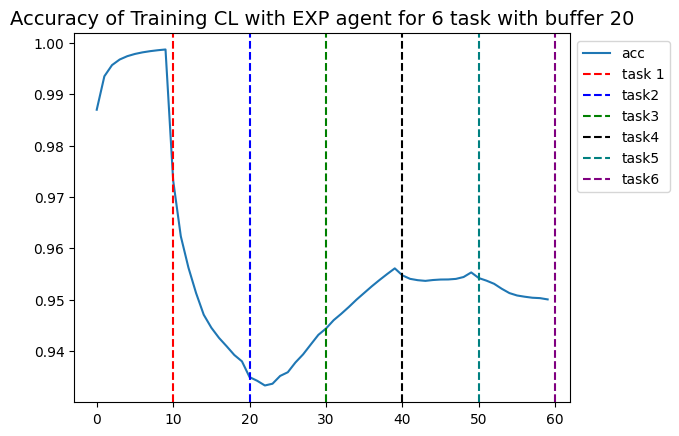

In [72]:
import matplotlib.pyplot as plt

plt.plot(agent.acc_epochs)
plt.axvline(x=10, linestyle = '--', color = 'r')
plt.axvline(x=20, linestyle = '--', color = 'b')
plt.axvline(x=30, linestyle = '--', color = 'g')
plt.axvline(x=40, linestyle = '--', color = 'black')
plt.axvline(x=50, linestyle = '--', color = 'teal')
plt.axvline(x=60, linestyle = '--', color = 'purple')
plt.title(f"Accuracy of Training CL with EXP agent for 6 task with buffer {params.mem_size}", fontsize = 14)
plt.legend(['acc', 'task 1', 'task2','task3','task4','task5', 'task6'],bbox_to_anchor=[1, 0.55],loc='lower left',)
plt.savefig(f"Acc_of_Training_CL_with_EXP_agent_for_6_task_with_buffer_{params.mem_size}.png")

plt.show()


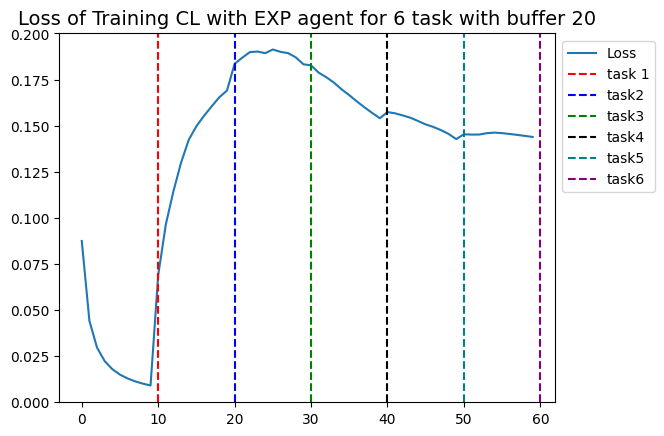

In [73]:
import matplotlib.pyplot as plt

plt.plot(agent.loss_epochs)
plt.axvline(x=10, linestyle = '--', color = 'r')
plt.axvline(x=20, linestyle = '--', color = 'b')
plt.axvline(x=30, linestyle = '--', color = 'g')
plt.axvline(x=40, linestyle = '--', color = 'black')
plt.axvline(x=50, linestyle = '--', color = 'teal')
plt.axvline(x=60, linestyle = '--', color = 'purple')
plt.title(f"Loss of Training CL with EXP agent for 6 task with buffer {params.mem_size}", fontsize = 14)
plt.legend(['Loss', 'task 1', 'task2','task3','task4','task5', 'task6'],bbox_to_anchor=[1, 0.55],loc='lower left',)
plt.savefig(f"Loss_of_Training_CL_with_EXP_agent_for_6_task_with_buffer_{params.mem_size}.png")
plt.show()

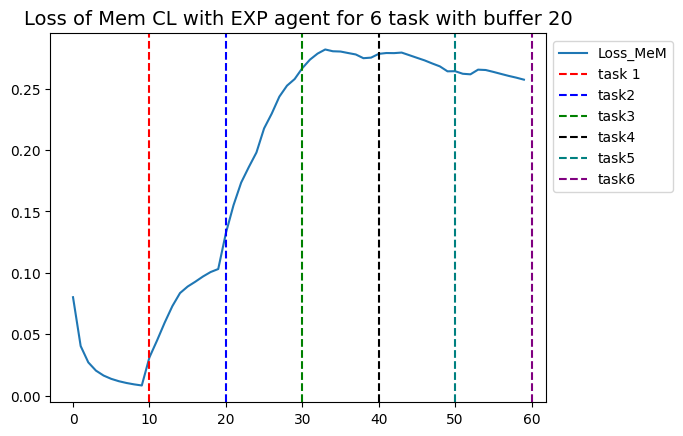

In [74]:
import matplotlib.pyplot as plt

plt.plot(agent.loss_mem_epochs)
plt.axvline(x=10, linestyle = '--', color = 'r')
plt.axvline(x=20, linestyle = '--', color = 'b')
plt.axvline(x=30, linestyle = '--', color = 'g')
plt.axvline(x=40, linestyle = '--', color = 'black')
plt.axvline(x=50, linestyle = '--', color = 'teal')
plt.axvline(x=60, linestyle = '--', color = 'purple')
plt.title(f"Loss of Mem CL with EXP agent for 6 task with buffer {params.mem_size}", fontsize = 14)
plt.legend(['Loss_MeM', 'task 1', 'task2','task3','task4','task5', 'task6'],bbox_to_anchor=[1, 0.55],loc='lower left',)
# plt.savefig(f"Loss of Mem CL with EXP agent for 6 task with buffer {params.mem_size}.png")
plt.savefig(f"Loss_of_MeM_CL_with_EXP_agent_for_6_task_with_buffer_{params.mem_size}.png")

plt.show()

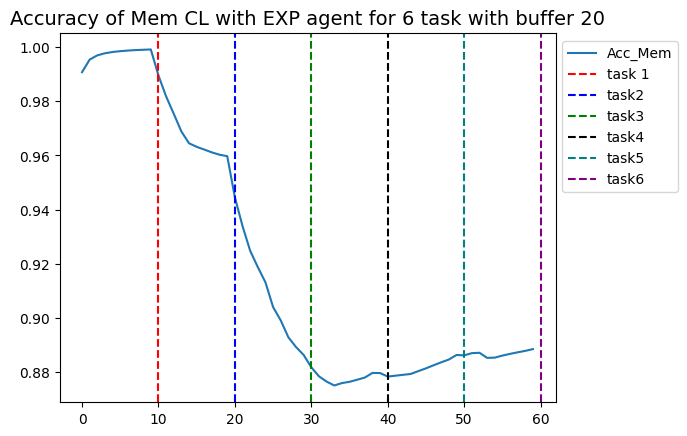

In [75]:
import matplotlib.pyplot as plt

plt.plot(agent.acc_mem_epochs)
plt.axvline(x=10, linestyle = '--', color = 'r')
plt.axvline(x=20, linestyle = '--', color = 'b')
plt.axvline(x=30, linestyle = '--', color = 'g')
plt.axvline(x=40, linestyle = '--', color = 'black')
plt.axvline(x=50, linestyle = '--', color = 'teal')
plt.axvline(x=60, linestyle = '--', color = 'purple')
plt.title(f"Accuracy of Mem CL with EXP agent for 6 task with buffer {params.mem_size}", fontsize = 14)
plt.legend(['Acc_Mem', 'task 1', 'task2','task3','task4','task5', 'task6'],bbox_to_anchor=[1, 0.55],loc='lower left',)
plt.savefig(f"Acc_of_MeM_CL_with_EXP_agent_for_6_task_with_buffer_{params.mem_size}.png")

plt.show()

In [76]:
accuracy_list

[array([[1.        , 0.        , 0.        , 0.        , 0.        ,
         0.        ],
        [0.99866489, 0.98952096, 0.        , 0.        , 0.        ,
         0.        ],
        [0.55674232, 0.8742515 , 1.        , 0.        , 0.        ,
         0.        ],
        [0.81842457, 0.99775449, 0.40419162, 0.9992515 , 0.        ,
         0.        ],
        [0.37716956, 0.95958084, 0.38323353, 0.48053892, 1.        ,
         0.        ],
        [0.33311081, 0.99401198, 0.43637725, 0.62125749, 0.57700977,
         1.        ]])]

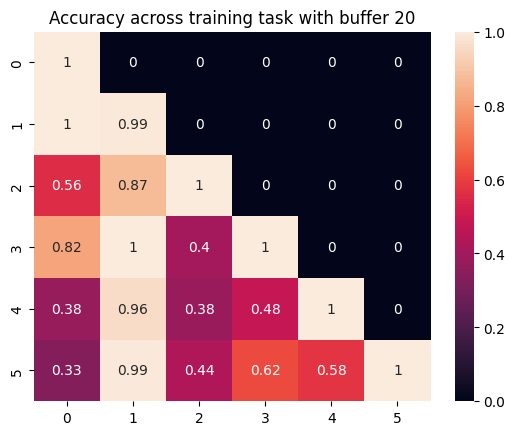

In [77]:
import seaborn as sns 

sns.heatmap(accuracy_list[0], annot=True)
plt.title(f"Accuracy across training task with buffer {params.mem_size}")
plt.savefig(f"Accuracy across evaluation task with buffer {params.mem_size}")
plt.show()

In [78]:
if params.online:
        avg_end_acc, avg_end_fgt, avg_acc, avg_bwtp, avg_fwt = compute_performance(accuracy_array)
        print('----------- Total {} run: {}s -----------'.format(params.num_runs, 0))
        print('----------- Avg_End_Acc {} Avg_End_Fgt {} Avg_Acc {} Avg_Bwtp {} Avg_Fwt {}-----------'
              .format(avg_end_acc, avg_end_fgt, avg_acc, avg_bwtp, avg_fwt))
else:
        print('----------- Total {} run: {}s -----------'.format(params.num_runs, 0))
        print("avg_end_acc {}".format(np.mean(accuracy_list)))



----------- Total 1 run: 0s -----------
----------- Avg_End_Acc (0.6602945480164106, nan) Avg_End_Fgt (0.33920644998758137, nan) Avg_Acc (0.8182881428280999, nan) Avg_Bwtp (0.0, nan) Avg_Fwt (0.0, nan)-----------


e:\New folder\conda_\envs\RL\lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
e:\New folder\conda_\envs\RL\lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [79]:
from scipy.stats import sem
import scipy.stats as stats

In [80]:
n_run, n_tasks = accuracy_array.shape[:2]
t_coef = stats.t.ppf((1+0.95) / 2, n_run-1)

In [81]:
n_run, t_coef

(1, nan)

In [82]:
acc_per_run = np.mean((np.sum(np.tril(accuracy_array), axis=2) /
                           (np.arange(n_tasks) + 1)), axis=1)
avg_acc = (np.mean(acc_per_run), t_coef * sem(acc_per_run))

In [83]:
(np.arange(n_tasks) + 1)

array([1, 2, 3, 4, 5, 6])

In [84]:
np.tril(accuracy_array)

array([[[1.        , 0.        , 0.        , 0.        , 0.        ,
         0.        ],
        [0.99866489, 0.98952096, 0.        , 0.        , 0.        ,
         0.        ],
        [0.55674232, 0.8742515 , 1.        , 0.        , 0.        ,
         0.        ],
        [0.81842457, 0.99775449, 0.40419162, 0.9992515 , 0.        ,
         0.        ],
        [0.37716956, 0.95958084, 0.38323353, 0.48053892, 1.        ,
         0.        ],
        [0.33311081, 0.99401198, 0.43637725, 0.62125749, 0.57700977,
         1.        ]]])

In [85]:
np.sum(np.tril(accuracy_array), axis=2) / (np.arange(n_tasks) + 1)

array([[1.        , 0.99409292, 0.81033127, 0.80490554, 0.64010457,
        0.66029455]])

In [86]:
acc_per_run

array([0.81828814])

In [87]:
avg_acc

(0.8182881428280999, nan)

In [88]:
#buffer size = 0 
#Avg_End_Acc (0.16666666666666666, nan) Avg_End_Fgt (0.8332082082082083, nan) Avg_Acc (0.408302052052052, nan) Avg_Bwtp (0.0, nan) Avg_Fwt (0.0, nan)

In [89]:
#buffer 5
# Avg_End_Acc (0.5746501564472365, nan) Avg_End_Fgt (0.4037031969061169, nan) Avg_Acc (0.6612165420848196, nan) Avg_Bwtp (0.0, nan) Avg_Fwt (0.0, nan)

In [90]:
#buffer 10
#  Avg_End_Acc (0.5639668111097742, nan) Avg_End_Fgt (0.3933657064246536, nan) Avg_Acc (0.7456068186063831, nan) Avg_Bwtp (0.0, nan) Avg_Fwt (0.0, nan)

In [91]:
#buffer = 15 
#Avg_End_Acc (0.6310428761456274, nan) Avg_End_Fgt (0.32796222561468713, nan) Avg_Acc (0.832879555717765, nan) Avg_Bwtp (0.0, nan) Avg_Fwt (0.0, nan)

In [92]:
#buffer = 20
# Avg_End_Acc (0.7416717171828456, nan) Avg_End_Fgt (0.23918446386625095, nan) Avg_Acc (0.830598300444635, nan) Avg_Bwtp (0.0, nan) Avg_Fwt (0.0, nan)

In [97]:
avg_end_acc = np.array([0.1666, 0.5726, 0.5639, 0.6310, 0.74116])
avg_acc = np.array([0.408302052052052,0.6612165420848196,0.7456068186063831,0.832879555717765, 0.830598300444635 ])
avg_end_fgt = np.array([0.8332082082082083, 0.4037031969061169,0.3933657064246536,0.32796222561468713,0.23918446386625095])

In [98]:
buffer = ['buffer 0', 'buffer 5', 'buffer 10', 'buffer 15', 'buffer 20']

In [99]:
import numpy as np
import matplotlib.pyplot as plt 

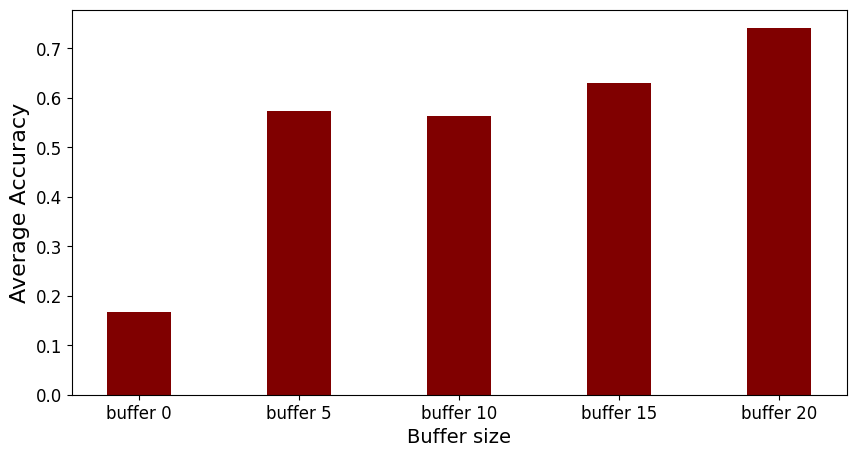

In [109]:
import numpy as np
import matplotlib.pyplot as plt 


# creating the dataset
data = {'C':20, 'C++':15, 'Java':30, 
		'Python':35}
courses = list(data.keys())
values = list(data.values())

fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(buffer, avg_end_acc, color ='maroon', 
		width = 0.4)

plt.xlabel("Buffer size", fontsize=14)
plt.ylabel("Average Accuracy", fontsize = 16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()


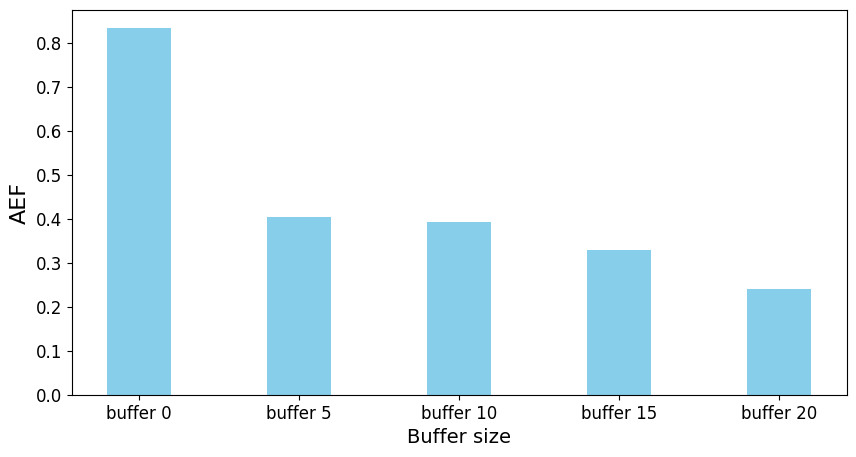

In [114]:
import numpy as np
import matplotlib.pyplot as plt 


# creating the dataset
data = {'C':20, 'C++':15, 'Java':30, 
		'Python':35}
courses = list(data.keys())
values = list(data.values())

fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(buffer, avg_end_fgt, color ='skyblue', 
		width = 0.4)
# plt.plot(avg_end_fgt)
plt.xlabel("Buffer size", fontsize=14)
plt.ylabel("AEF", fontsize = 16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

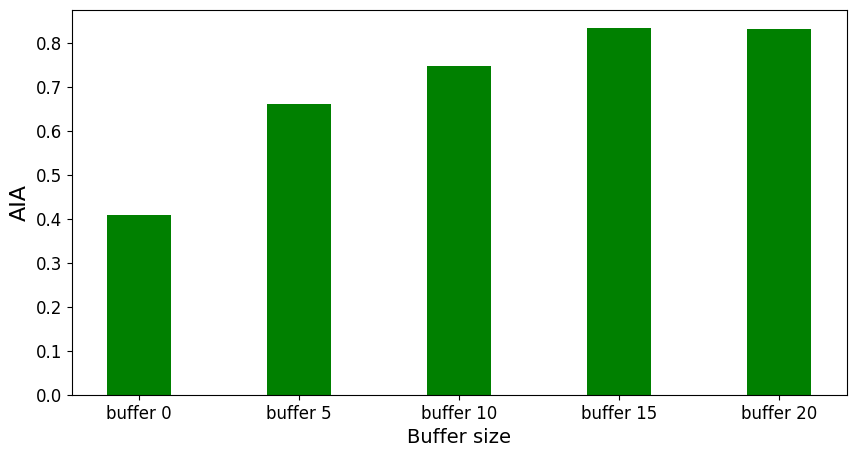

In [117]:
import numpy as np
import matplotlib.pyplot as plt 


# creating the dataset
data = {'C':20, 'C++':15, 'Java':30, 
		'Python':35}
courses = list(data.keys())
values = list(data.values())

fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(buffer, avg_acc, color ='green', 
		width = 0.4)
# plt.plot(avg_end_fgt)
plt.xlabel("Buffer size", fontsize=14)
plt.ylabel("AIA", fontsize = 16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [2]:
labels = ["Right", "RightUp", "UpRight", "Up", "UpLeft", "LeftUp", "Left", "LeftDown", "DownLeft", "Down", "DownRight", "RightDown"]
len(labels)

12

## Inference model 

In [7]:
import torch 
import torch.nn as nn
import torchvision
from torchvision import transforms


In [8]:
model_buffer = torch.load("./workdir/lstm_model_buffer0.pt")
model_buffer5 = torch.load("./workdir/lstm_model_buffer5.pt")
model_buffer10 = torch.load("./workdir/lstm_model_buffer10.pt")
model_buffer15 = torch.load("./workdir/lstm_model_buffer15.pt")
model_buffer20 = torch.load("./workdir/lstm_model_buffer20.pt")



In [9]:
data_transform = transforms.Compose([ transforms.ToTensor()])

In [10]:
cl_type = params.cl_type

In [13]:
start = time.time()
print('Setting up data stream')
data_continuum = continuum("breathing_v2", cl_type, params)
data_end = time.time()
print('data setup time: {}'.format(data_end - start))

Setting up data stream
Generate Slice Window data successfully
Generate Slice Window data successfully
data setup time: 0.1601724624633789


In [14]:
data = data_continuum.data_object.test_data
label_test = data_continuum.data_object.test_label

In [15]:
from torch.utils.data import TensorDataset, DataLoader

In [16]:
data_tensor = torch.from_numpy(data)
label_tensor = torch.from_numpy(label_test)

In [17]:
from models.lstm import LSTMModel
import torchinfo

In [18]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [19]:
input_dim = 3
hidden_dim = 100
sequence_dim = 28
layer_dim = 1
output_dim = 10
model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim).to(device)
print(model.eval)

<bound method Module.eval of LSTMModel(
  (lstm): LSTM(3, 100, batch_first=True)
  (linear): Linear(in_features=100, out_features=10, bias=True)
)>


In [20]:
from continuum.data_utils import dataset_transform
from utils.setup_elements import transforms_match


In [21]:
data.shape

(7999, 20, 3)

In [22]:
eval_dataset = dataset_transform(x=data, y=label_test, transform=transforms_match['breathing'])
eval_loader = DataLoader(eval_dataset, batch_size=3000, shuffle=True, num_workers=0,
                                       drop_last=True)

In [23]:
X_batch, y_batch = next(iter(eval_loader))

In [24]:
X_x = X_batch.view(3000, 20, 3)

In [26]:
out_model_0 = model_buffer(X_batch)
out_model_5 = model_buffer5(X_batch)
out_model_10 = model_buffer10(X_batch)
out_model_15 = model_buffer15(X_batch)
out_model_20 = model_buffer20(X_batch)


In [32]:
import numpy as np
from sklearn.manifold import TSNE
import time


In [33]:
start = time.time()
tsne_b0 = TSNE(n_components=3).fit_transform(out_model_0.detach().numpy())
tsne_b5 = TSNE(n_components=3).fit_transform(out_model_5.detach().numpy())
tsne_b10 = TSNE(n_components=3).fit_transform(out_model_10.detach().numpy())
tsne_b15= TSNE(n_components=3).fit_transform(out_model_15.detach().numpy())
tsne_b20= TSNE(n_components=3).fit_transform(out_model_20.detach().numpy())

print("time processing t-NSE: ", time.time() - start)

time processing t-NSE:  160.83507823944092


In [34]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns


In [35]:
from sklearn.metrics import confusion_matrix

In [36]:
df_0 = pd.DataFrame({"t-sne 1":tsne_b0[:,0],
                   "t-sne 2":tsne_b0[:,1],
                   "t-sne 3":tsne_b0[:,2],
                   "Lables":y_batch.detach().numpy()})

In [37]:
df_5 = pd.DataFrame({"t-sne 1":tsne_b5[:,0],
                   "t-sne 2":tsne_b5[:,1],
                   "t-sne 3":tsne_b5[:,2],
                   "Lables":y_batch.detach().numpy()})

In [38]:
df_10 = pd.DataFrame({"t-sne 1":tsne_b10[:,0],
                   "t-sne 2":tsne_b10[:,1],
                   "t-sne 3":tsne_b10[:,2],
                   "Lables":y_batch.detach().numpy()})

In [39]:
df_15 = pd.DataFrame({"t-sne 1":tsne_b15[:,0],
                   "t-sne 2":tsne_b15[:,1],
                   "t-sne 3":tsne_b15[:,2],
                   "Lables":y_batch.detach().numpy()})

In [40]:
df_20 = pd.DataFrame({"t-sne 1":tsne_b20[:,0],
                   "t-sne 2":tsne_b20[:,1],
                   "t-sne 3":tsne_b20[:,2],
                   "Lables":y_batch.detach().numpy()})

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\TAOSTORE\AppData\Local\Temp\ipykernel_11648\2086016152.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


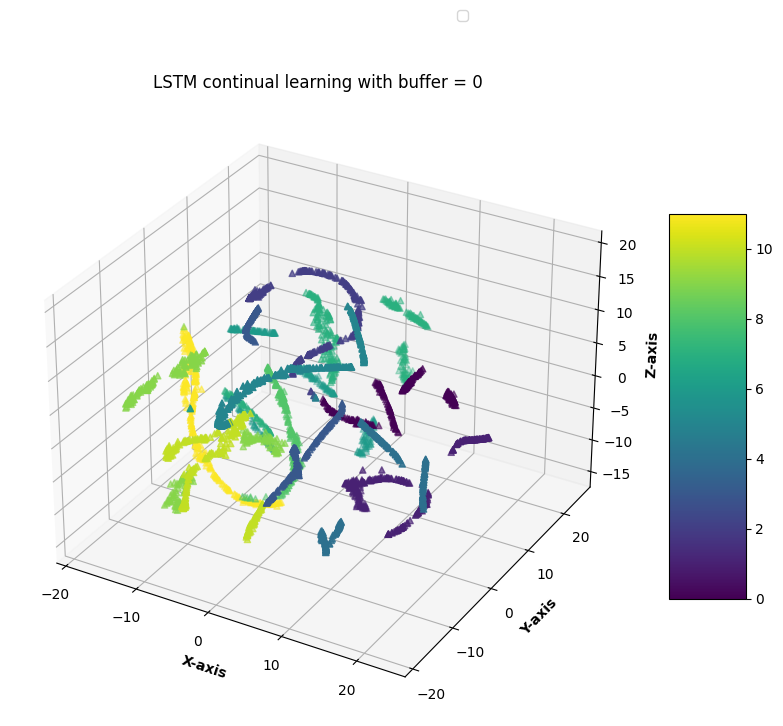

In [41]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
scct = ax.scatter3D(df_0['t-sne 1'], df_0['t-sne 2'], df_0['t-sne 3'],c=df_0['Lables'],marker ='^')
plt.title("LSTM continual learning with buffer = 0 ")
ax.set_xlabel('X-axis', fontweight ='bold') 
ax.set_ylabel('Y-axis', fontweight ='bold') 
ax.set_zlabel('Z-axis', fontweight ='bold')
fig.colorbar(scct, ax = ax, shrink = 0.5, aspect = 5)
plt.legend(bbox_to_anchor =(0.75, 1.15))
fig.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\TAOSTORE\AppData\Local\Temp\ipykernel_11648\230201876.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


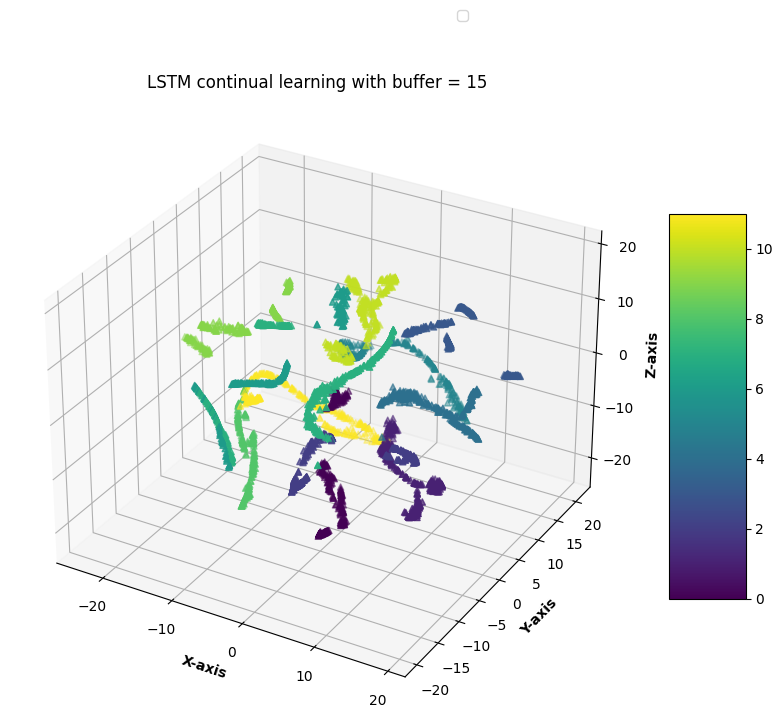

In [42]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
scct = ax.scatter3D(df_15['t-sne 1'], df_15['t-sne 2'], df_15['t-sne 3'],c=df_15['Lables'],marker ='^')
plt.title("LSTM continual learning with buffer = 15 ")
ax.set_xlabel('X-axis', fontweight ='bold') 
ax.set_ylabel('Y-axis', fontweight ='bold') 
ax.set_zlabel('Z-axis', fontweight ='bold')
fig.colorbar(scct, ax = ax, shrink = 0.5, aspect = 5)
plt.legend(bbox_to_anchor =(0.75, 1.15))
fig.show()

In [ ]:
y_pre_0 = np.argmax(out_model_0.detach().numpy(), axis=1)
y_pre_5 = np.argmax(out_model_5.detach().numpy(), axis=1)
y_pre_10 = np.argmax(out_model_10.detach().numpy(), axis=1)
y_pre_15 = np.argmax(out_model_15.detach().numpy(), axis=1)
y_pre_20 = np.argmax(out_model_20.detach().numpy(), axis=1)


In [29]:
y_batch.detach().numpy()

array([ 2,  1,  5, ..., 10,  3,  1], dtype=int64)

In [30]:
cf_0 = confusion_matrix(y_true=y_batch.detach().numpy(), y_pred=y_pre_0, )
cf_5 = confusion_matrix(y_true=y_batch.detach().numpy(), y_pred=y_pre_5, )
cf_10 = confusion_matrix(y_true=y_batch.detach().numpy(), y_pred=y_pre_10, )
cf_15 = confusion_matrix(y_true=y_batch.detach().numpy(), y_pred=y_pre_15, )
cf_20 = confusion_matrix(y_true=y_batch.detach().numpy(), y_pred=y_pre_20, )


In [46]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

In [68]:
import seaborn as sns

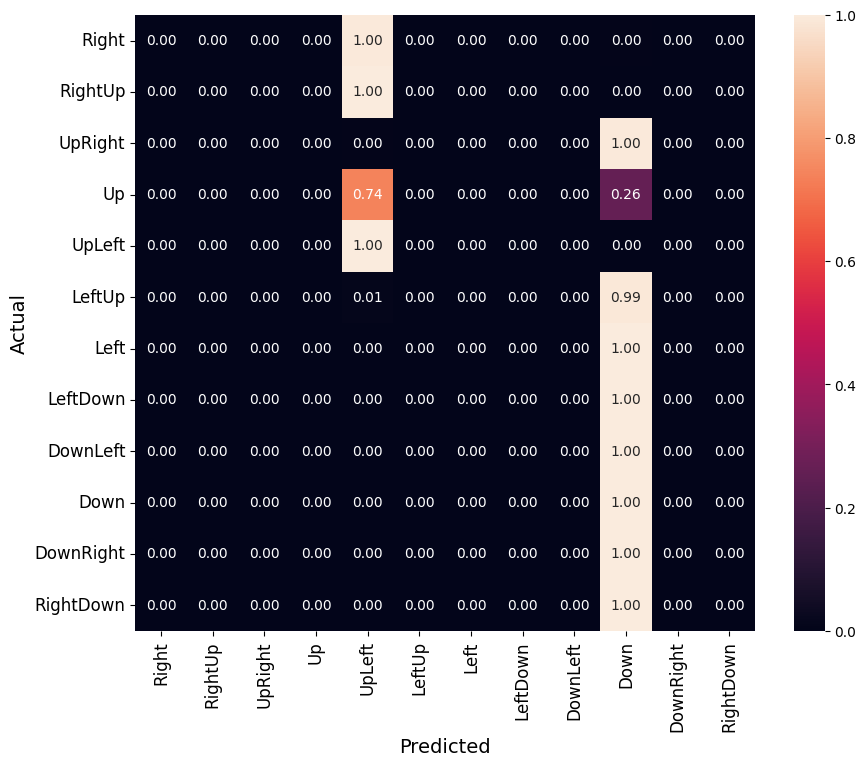

In [90]:
cmn = cf_0.astype('float') / cf_0.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual', fontsize=14)
plt.xlabel('Predicted',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig("cf_0.png")
plt.show(block=False)

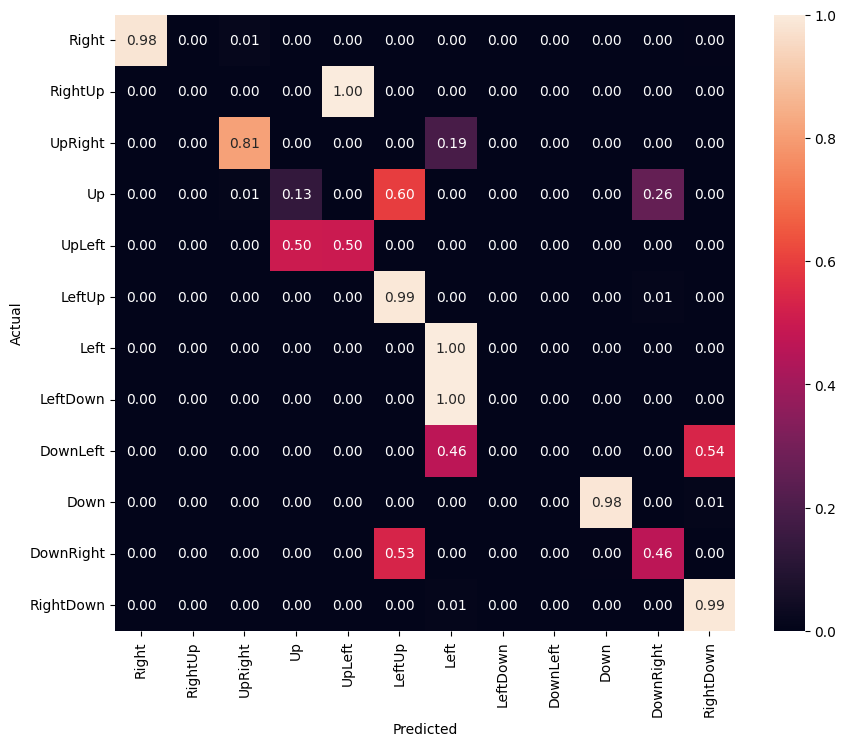

In [83]:
cmn_5 = cf_5.astype('float') / cf_5.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(cmn_5, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

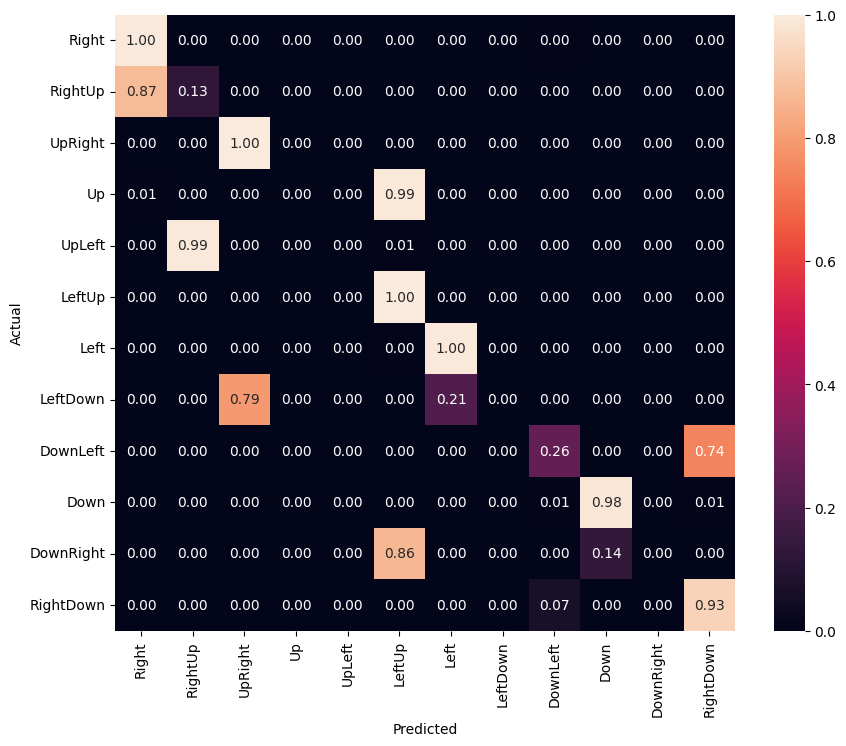

In [84]:
cmn_10 = cf_10.astype('float') / cf_10.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(cmn_10, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

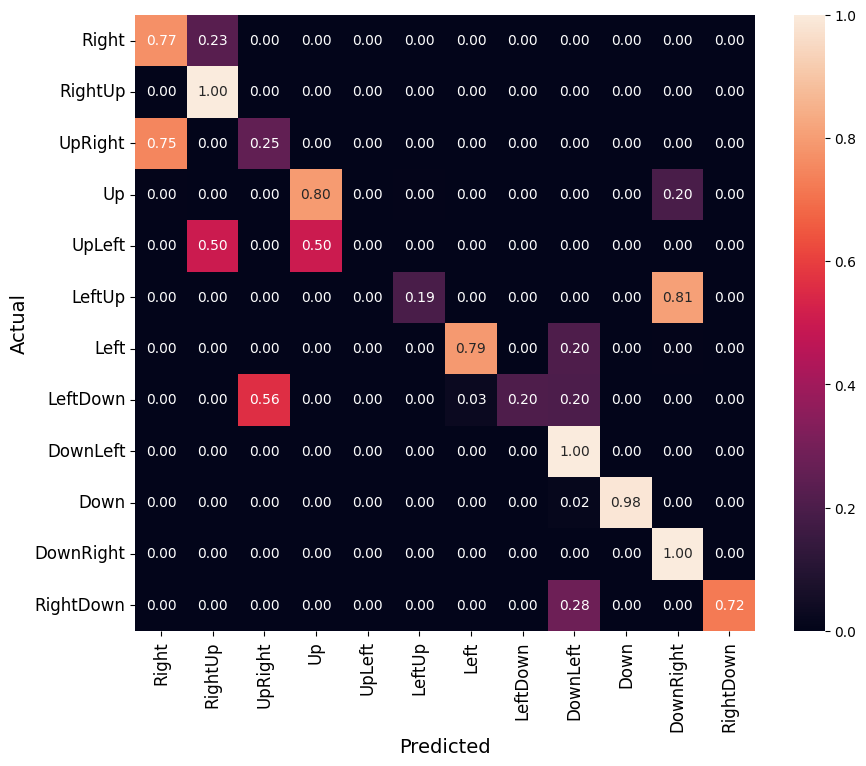

In [93]:
cmn_15 = cf_15.astype('float') / cf_15.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(cmn_15, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual', fontsize=14)
plt.xlabel('Predicted',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig("cf_15.png")
plt.show(block=False)

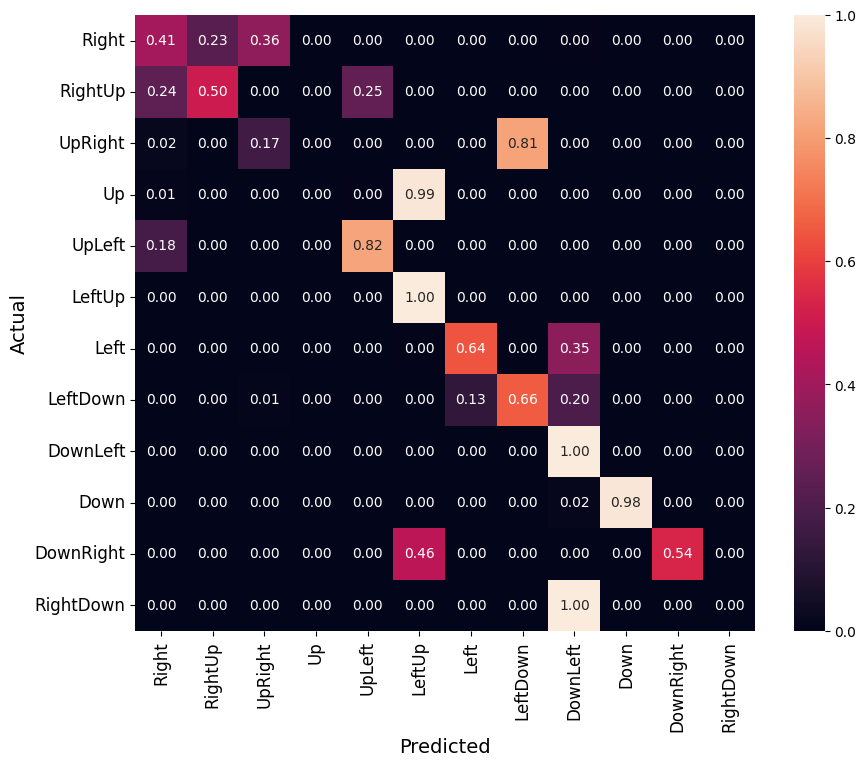

In [92]:
cmn_20 = cf_20.astype('float') / cf_20.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(cmn_20, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual', fontsize=14)
plt.xlabel('Predicted',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig("cf_20.png")
plt.show(block=False)

In [44]:
out_b0, _= model_buffer.lstm.forward(X_x)
out_b5, _= model_buffer5.lstm.forward(X_x)
out_b10, _= model_buffer10.lstm.forward(X_x)
out_b15, _= model_buffer15.lstm.forward(X_x)
out_b20, _= model_buffer20.lstm.forward(X_x)



In [45]:
out_lstm_b0 = out_b0[:, -1, :]
out_lstm_b5 = out_b5[:, -1, :]
out_lstm_b10 = out_b10[:, -1, :]
out_lstm_b15 = out_b15[:, -1, :]


In [46]:
import numpy as np
from sklearn.manifold import TSNE
import time


In [57]:
start = time.time()
tsne_b0 = TSNE(n_components=2).fit_transform(out_lstm_b0.detach().numpy())
tsne_b5 = TSNE(n_components=2).fit_transform(out_lstm_b5.detach().numpy())
tsne_b10 = TSNE(n_components=2).fit_transform(out_lstm_b10.detach().numpy())
tsne_b15= TSNE(n_components=2).fit_transform(out_lstm_b15.detach().numpy())
print("time processing t-NSE: ", time.time() - start)

time processing t-NSE:  50.69595170021057


In [58]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns


In [60]:
df_0 = pd.DataFrame({"t-sne 1":tsne_b0[:,0],
                   "t-sne 2":tsne_b0[:,1],
                #    "t-sne 3":tsne_b0[:,2],
                   "Lables":y_batch.detach().numpy()})

In [62]:
df_5 = pd.DataFrame({"t-sne 1":tsne_b5[:,0],
                   "t-sne 2":tsne_b5[:,1],
                #    "t-sne 3":tsne_b5[:,2],
                   "Lables":y_batch})

In [63]:
df_10 = pd.DataFrame({"t-sne 1":tsne_b10[:,0],
                   "t-sne 2":tsne_b10[:,1],
                #    "t-sne 3":tsne_b10[:,2],
                   "Lables":y_batch})

In [64]:
df_15 = pd.DataFrame({"t-sne 1":tsne_b15[:,0],
                   "t-sne 2":tsne_b15[:,1],
                #    "t-sne 3":tsne_b15[:,2],
                   "Lables":y_batch})

In [ ]:
y_batch.detach().numpy()

array([ 6,  9,  4, ..., 11, 10,  8], dtype=int64)

In [ ]:
np.unique(df_0['Lables'].values)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=int64)

In [ ]:
X

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


C:\Users\TAOSTORE\AppData\Local\Temp\ipykernel_11648\203367587.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


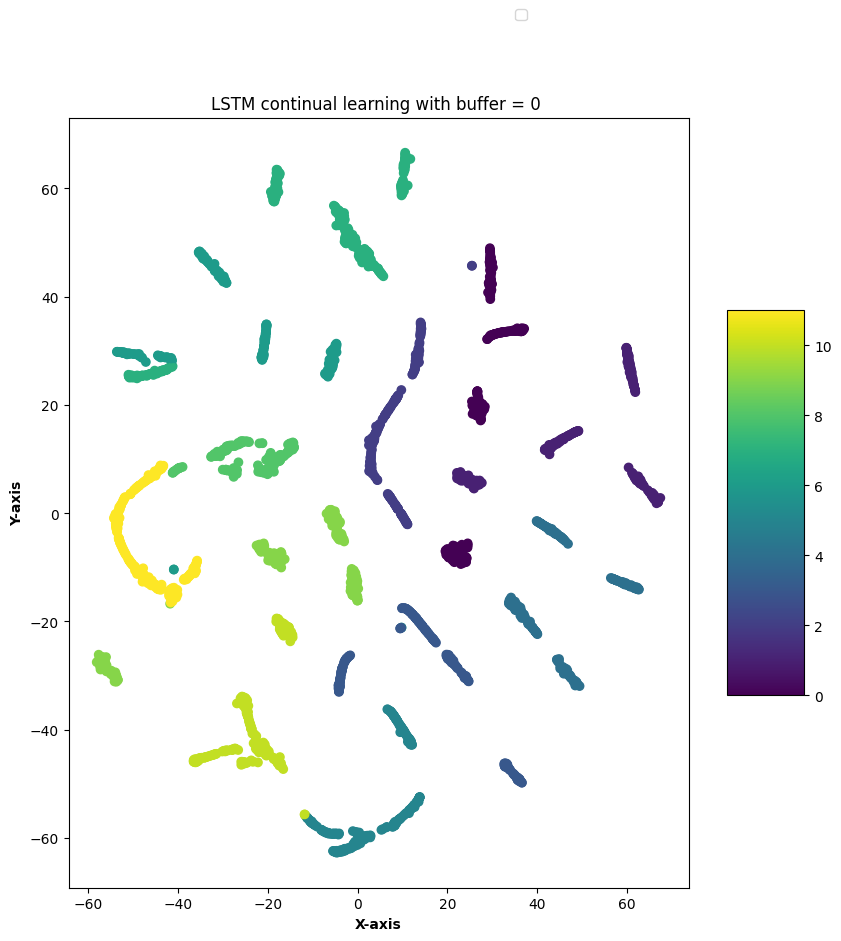

In [70]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 10))
ax = plt.axes()
# scct = ax.scatter3D(df_0['t-sne 1'], df_0['t-sne 2'], df_0['t-sne 3'],c=df_0['Lables'])
ax.scatter(df_0['t-sne 1'], df_0['t-sne 2'],c=df_0['Lables'])
plt.title("LSTM continual learning with buffer = 0 ")
ax.set_xlabel('X-axis', fontweight ='bold') 
ax.set_ylabel('Y-axis', fontweight ='bold') 
# ax.set_zlabel('Z-axis', fontweight ='bold')
fig.colorbar(scct, ax = ax, shrink = 0.5, aspect = 5)
plt.legend(bbox_to_anchor =(0.75, 1.15))
fig.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\TAOSTORE\AppData\Local\Temp\ipykernel_11648\2725723668.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


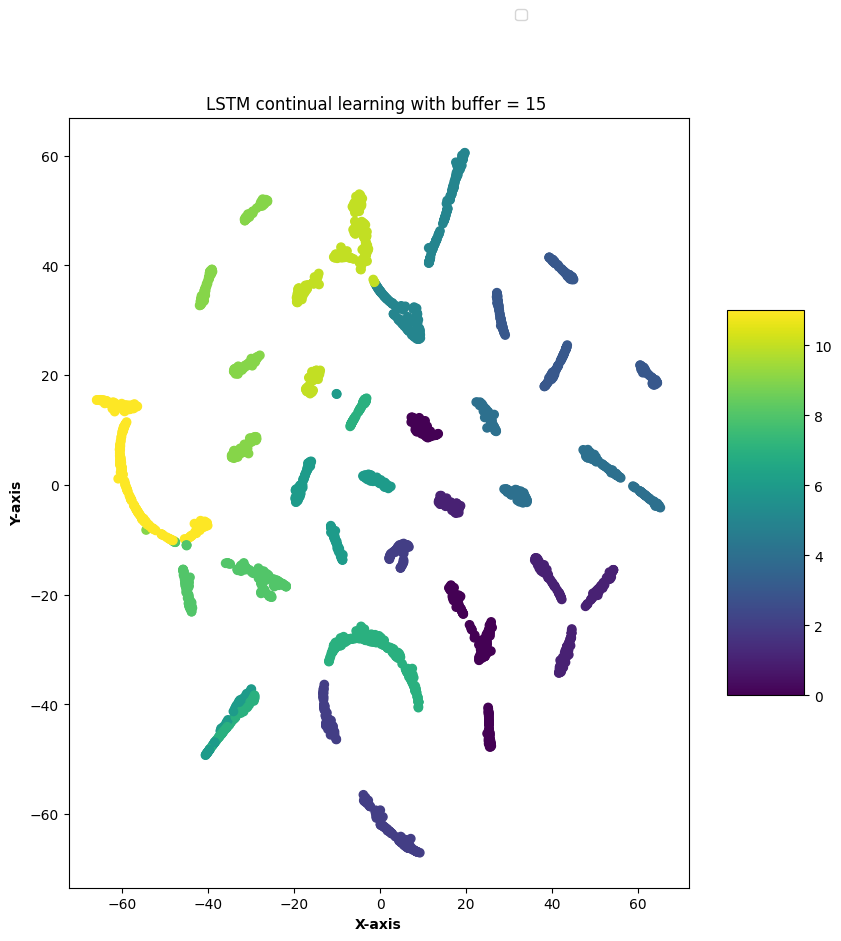

In [71]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 10))
ax = plt.axes()
# scct = ax.scatter3D(df_0['t-sne 1'], df_0['t-sne 2'], df_0['t-sne 3'],c=df_0['Lables'])
ax.scatter(df_15['t-sne 1'], df_15['t-sne 2'],c=df_15['Lables'])
plt.title("LSTM continual learning with buffer = 15 ")
ax.set_xlabel('X-axis', fontweight ='bold') 
ax.set_ylabel('Y-axis', fontweight ='bold') 
# ax.set_zlabel('Z-axis', fontweight ='bold')
fig.colorbar(scct, ax = ax, shrink = 0.5, aspect = 5)
plt.legend(bbox_to_anchor =(0.75, 1.15))
fig.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


C:\Users\TAOSTORE\AppData\Local\Temp\ipykernel_11648\3483878480.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


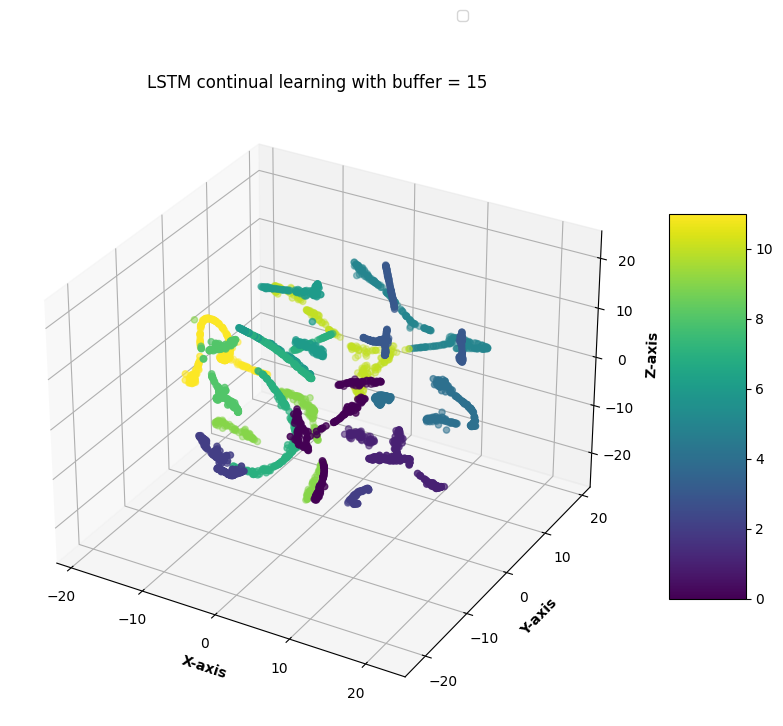

In [54]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.scatter3D(df_15['t-sne 1'], df_15['t-sne 2'], df_15['t-sne 3'], c=df_15['Lables'])
plt.title("LSTM continual learning with buffer = 15 ")
ax.set_xlabel('X-axis', fontweight ='bold') 
ax.set_ylabel('Y-axis', fontweight ='bold') 
ax.set_zlabel('Z-axis', fontweight ='bold')
fig.colorbar(scct, ax = ax, shrink = 0.5, aspect = 5)
plt.legend(bbox_to_anchor =(0.75, 1.15))
fig.show()
plt.show()

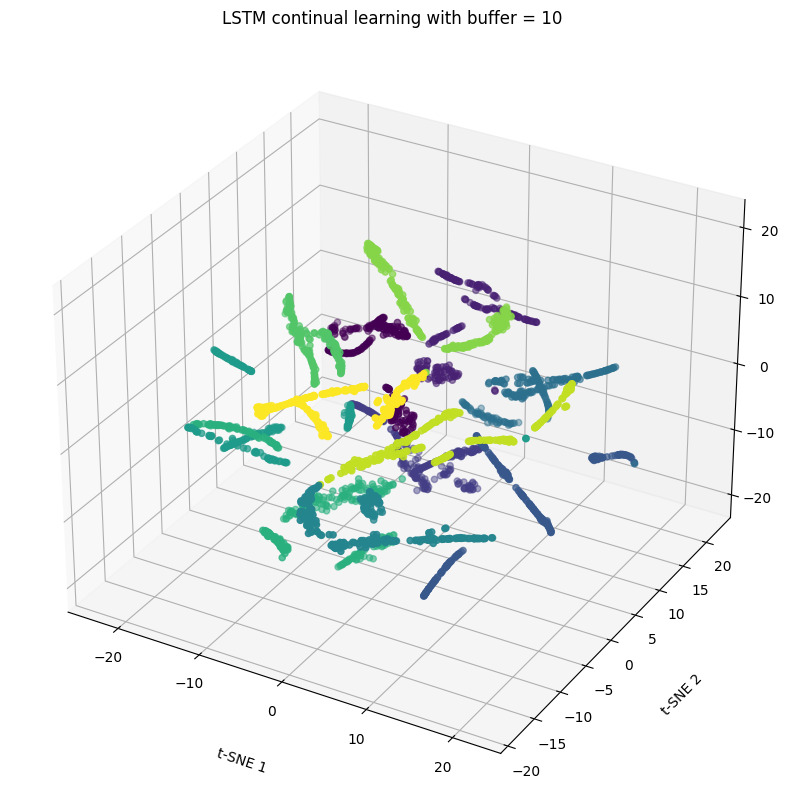

In [55]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.scatter3D(df_10['t-sne 1'], df_10['t-sne 2'], df_10['t-sne 3'], c=df_10['Lables'])
plt.title("LSTM continual learning with buffer = 10 ")
ax.set_xlabel('t-SNE 1', labelpad=20)
ax.set_ylabel( 't-SNE 2', labelpad=20)
ax.set_zlabel('t-SNE 3', labelpad=20)
plt.show()

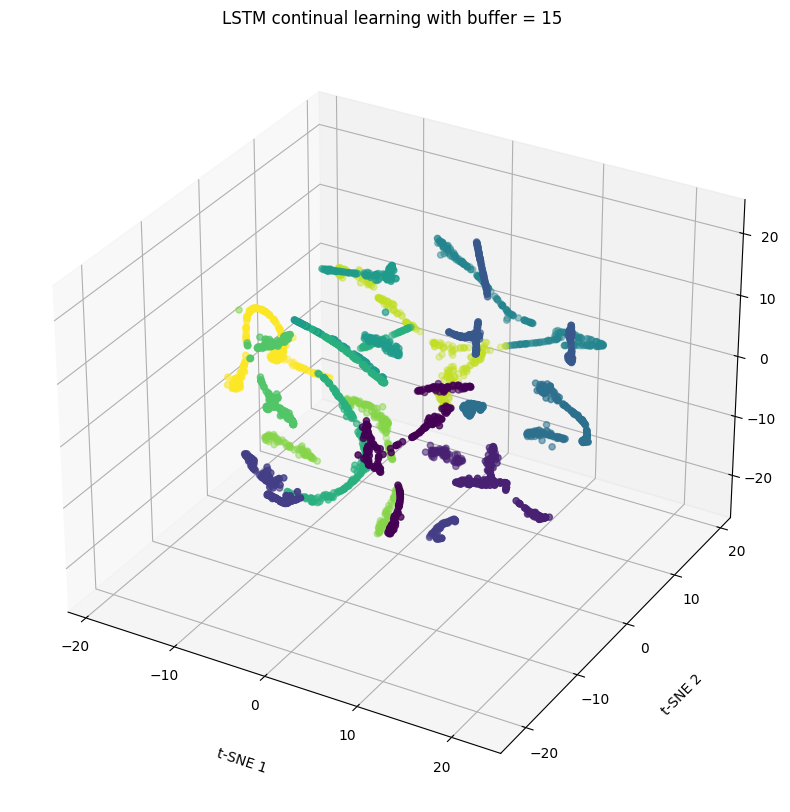

In [56]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.scatter3D(df_15['t-sne 1'], df_15['t-sne 2'], df_15['t-sne 3'], c=df_15['Lables'])
plt.title("LSTM continual learning with buffer = 15 ")
ax.set_xlabel('t-SNE 1', labelpad=20)
ax.set_ylabel( 't-SNE 2', labelpad=20)
ax.set_zlabel('t-SNE 3', labelpad=20)
plt.show()